In [1]:
from eclipsoid.oblate import OblateSystem, OblateBody, OblateTransitOrbit
from eclipsoid.light_curve import oblate_lightcurve, legacy_oblate_lightcurve, oblate_lightcurve_fast

from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit
import jax
import jax.numpy as jnp

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2, 0.1, 0.1]),
          'f':0.,
          'bo':0.8,
          'duration':0.4,
          'theta':0.
}

orbit = TransitOrbit(
    period=params['period'], time_transit=0., duration=params['duration'], impact_param=params['bo'], radius=params['radius']
)
oblate_orbit = OblateTransitOrbit(
    period=params['period'], time_transit=0., duration=params['duration'], impact_param=params['bo'], radius=params['radius'], f=params['f'], theta=params['theta']
)

t = jnp.linspace(-0.3, 0.3, 200)
lc = limb_dark_light_curve(orbit, params['u'])(t)

oblate_lc = oblate_lightcurve(orbit=oblate_orbit, u=params['u'])(time=t)
oblate_lc_fast = oblate_lightcurve_fast(orbit=oblate_orbit, u=params['u'])(time=t)
params['radius'] = params['radius']/jnp.sqrt(1-params['f'])
legacy_oblate_lc = legacy_oblate_lightcurve(params, t=t)

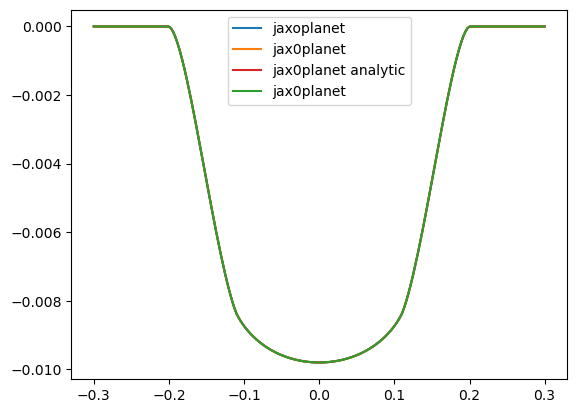

In [3]:
import matplotlib.pyplot as plt
plt.plot(t, lc, color="C0", label='jaxoplanet')
plt.plot(t, oblate_lc-1., color="C1", label='jax0planet')
plt.plot(t, oblate_lc_fast-1., color="C3", label='jax0planet analytic')

plt.plot(t, legacy_oblate_lc-1., color="C2", label='jax0planet')

plt.legend()

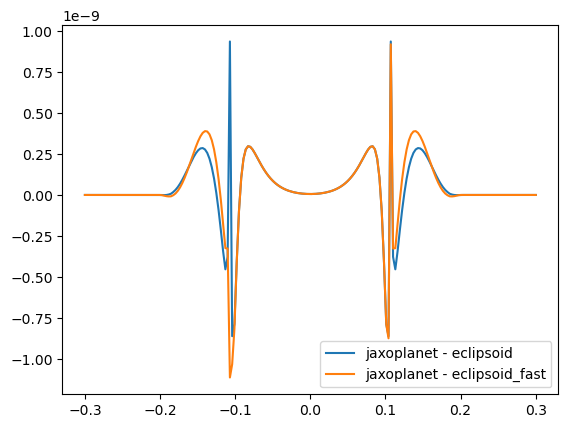

In [4]:
plt.plot(t, lc-(oblate_lc-1.), label='jaxoplanet - eclipsoid')
plt.plot(t, lc-(oblate_lc_fast-1.), label='jaxoplanet - eclipsoid_fast')
plt.legend()

In [5]:
from jaxoplanet.orbits.keplerian import Central
central = Central(radius=1.0, mass=0.8)
oblate_system = OblateSystem(central).add_body(
    radius=0.1, mass=0.1, period=300.456, f=0.0, theta=10.0
)

In [6]:
jit_lc = jax.jit(limb_dark_light_curve(orbit, params['u']))
circ_lc = jit_lc(t)

In [7]:
oblate_lc_jit = jax.jit(oblate_lightcurve(orbit=oblate_system, u=params['u']))
oblate_lc_fast_jit = jax.jit(oblate_lightcurve_fast(orbit=oblate_system, u=params['u']))

oblate_lc_system = oblate_lc_jit(time=t)

In [8]:
%%timeit
circ_lc = jit_lc(t).block_until_ready()

75.9 µs ± 203 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
%%timeit
oblate_lc_system = oblate_lc_jit(time=t).block_until_ready()

4.06 ms ± 23.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit
oblate_lc_system = oblate_lc_fast_jit(time=t).block_until_ready()

1.11 ms ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


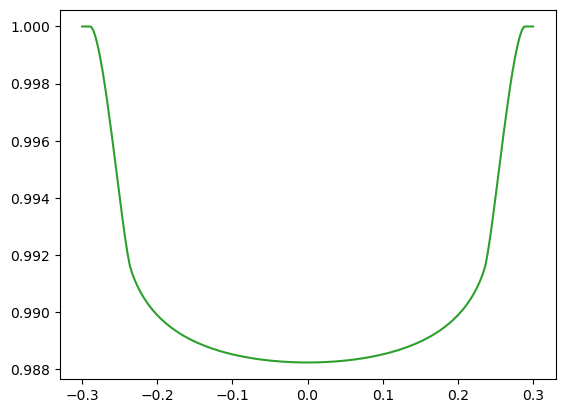

In [11]:
plt.plot(t, oblate_lc_system, color="C2", label='jax0planet system')

## Testing out exposure time integration:

In [12]:
from jaxoplanet.light_curves.transforms import integrate
from jaxoplanet.units import unit_registry as ureg
lc_integrated = integrate(oblate_lightcurve(orbit=oblate_orbit, u=params['u']), exposure_time=0.5*ureg.hour)

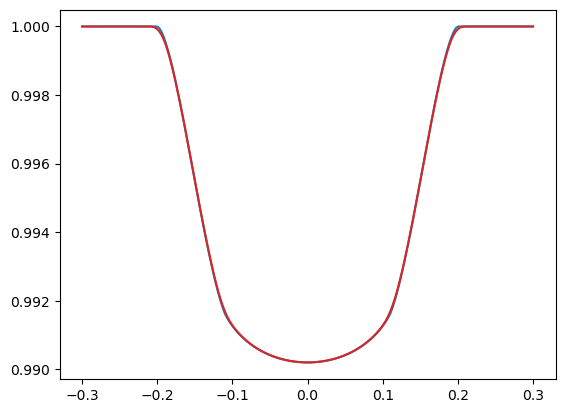

In [13]:
oblate_lc_integrated = lc_integrated(time=t)
plt.plot(t, oblate_lc)
plt.plot(t, oblate_lc_integrated, color="C3", label='jax0planet integrated')